In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 16.9 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 20.3 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [3]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]


In [5]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]d-learn]


In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd
import h5py
import numpy as np

In [2]:
def generate_engineered_dset(filepath, num_rows=None):
    with h5py.File(filepath, "r") as f:
        X_dset = f["phi"]
        y_dset = f["is_pulsar"]
        total_rows = X_dset.shape[0]

        if num_rows is not None:
            idx = np.random.choice(total_rows, size=num_rows, replace=False)
            idx.sort()
        else:
            # take entire dataset
            idx = np.arange(total_rows)

        X = X_dset[idx]
        y = y_dset[idx]

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y)

    pulsars_df = X_df[(y_df == 1).values]
    bh_df      = X_df[(y_df == 0).values]

    def row_summary_stats(df):
        num_df = df.select_dtypes(include='number')
        summary = pd.DataFrame({
            'mean':     num_df.mean(axis=1),
            'std':      num_df.std(axis=1),
            'min':      num_df.min(axis=1),
            'q1':       num_df.quantile(0.25, axis=1),
            'median':   num_df.quantile(0.50, axis=1),
            'q3':       num_df.quantile(0.75, axis=1),
            'max':      num_df.max(axis=1),
            'iqr':      num_df.quantile(0.75, axis=1) - num_df.quantile(0.25, axis=1),
            'skew':     num_df.skew(axis=1),
            'kurtosis': num_df.kurtosis(axis=1)
        })
        return summary

    p_row_stats = row_summary_stats(pulsars_df)
    bh_row_stats = row_summary_stats(bh_df)
    p_row_stats["label"] = "pulsar"
    bh_row_stats["label"] = "bh"

    return pd.concat([p_row_stats, bh_row_stats]).reset_index(drop=True)

In [3]:
def split_to_X_y(test_df):
    mapping = dict(enumerate(df['label'].astype('category').cat.categories))
    print(mapping)
    reverse_mapping = {v: k for k, v in mapping.items()}
    return test_df.drop(columns=["label"]), test_df["label"].map(reverse_mapping)

In [4]:
# filepath = "/home/idies/workspace/Storage/002375816/persistent/full_1800.h5"

In [5]:
# df = generate_engineered_dset(filepath)
# df.shape, df.head()

In [6]:
file = '/home/idies/workspace/Storage/dyu/persistent/full_1800_stats.h5'

with h5py.File(file, 'r') as f:
    X = f['phi_stats'][:]
    y = f['is_pulsar'][:]

In [7]:
# X, y = split_to_X_y(df)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class proportions consistent
)

In [9]:
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
neg = np.sum(y_train == 0)   # count of class 0 (bh)
pos = np.sum(y_train == 1)   # count of class 1 (pulsar)

ratio = neg / pos
ratio

np.float64(2.743607265371947)

In [10]:
clf = XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",   # fast GPU-like speed on CPU
    scale_pos_weight=ratio,
)


In [11]:
clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [12]:
train_acc = clf.score(X_train, y_train)
print("Training Accuracy:", train_acc)

Training Accuracy: 0.9389520875012778


In [13]:
y_pred = clf.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     50187
           1       0.80      0.92      0.85     18293

    accuracy                           0.92     68480
   macro avg       0.88      0.92      0.90     68480
weighted avg       0.92      0.92      0.92     68480



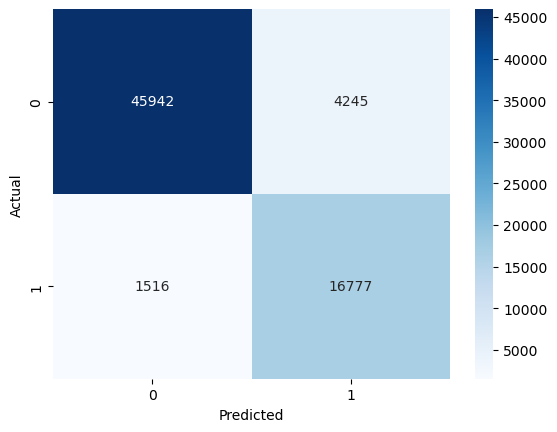

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
# If explainer returns a list (tree models sometimes do)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # use positive class


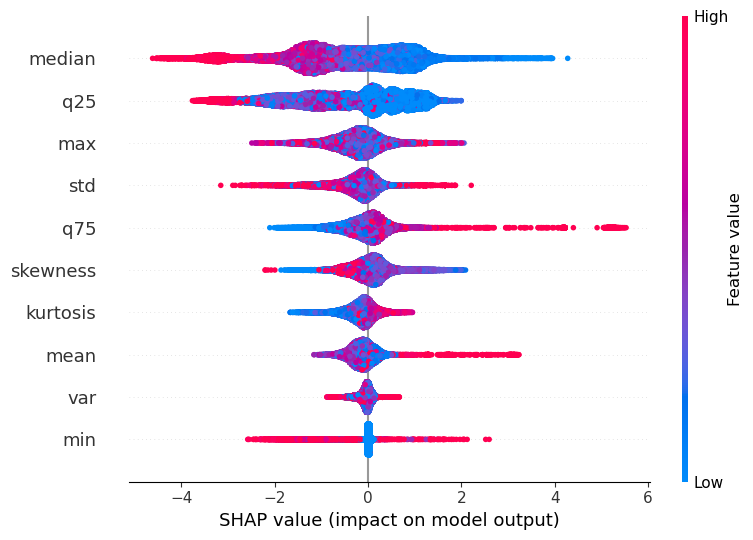

In [17]:
names = ['mean','std','min','q25','median','q75','max','var','skewness','kurtosis']

X_test_df = pd.DataFrame(X_test, columns=names)

shap.summary_plot(shap_values, X_test_df)

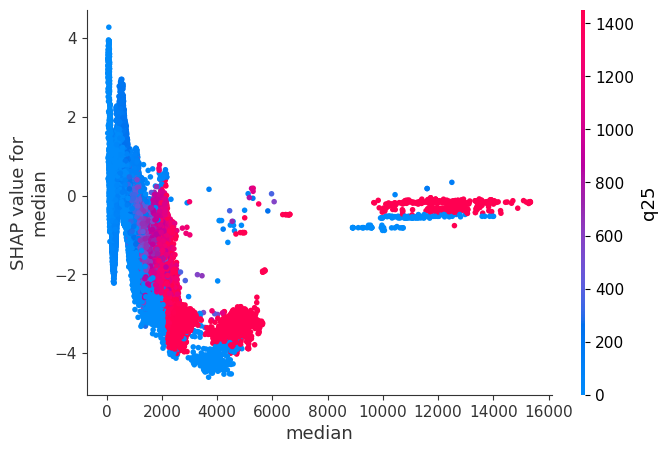

In [31]:
shap.dependence_plot("median", shap_values, X_test_df)

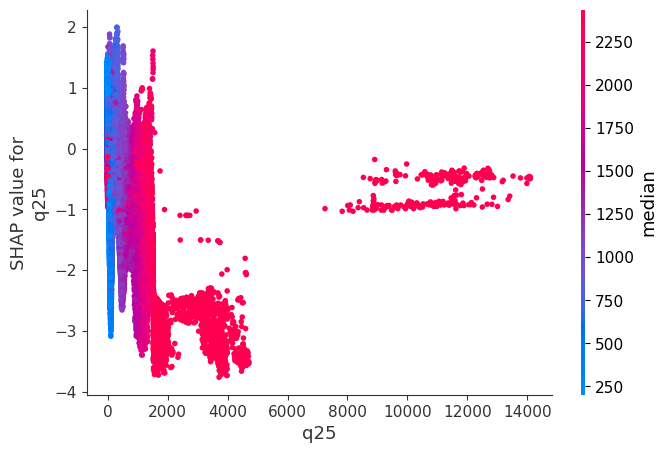

In [34]:
shap.dependence_plot("q25", shap_values, X_test_df)

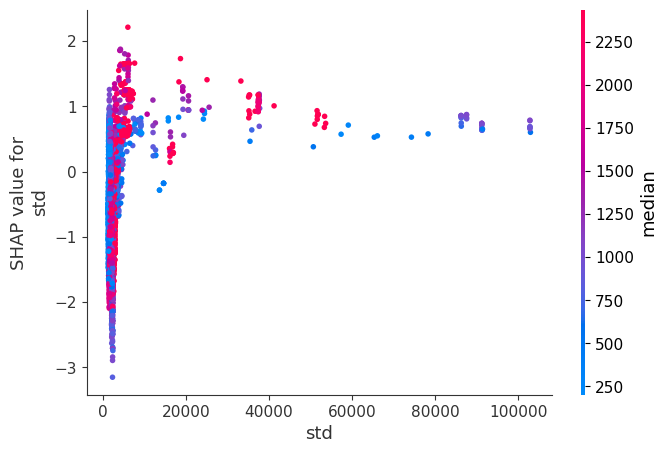

In [33]:
shap.dependence_plot("std", shap_values, X_test_df)

In [21]:
clf.save_model("xgboost_large.json")

In [ ]:
i = 1
shap.decision_plot(explainer.expected_value, shap_values[i], X_test_df.iloc[i])

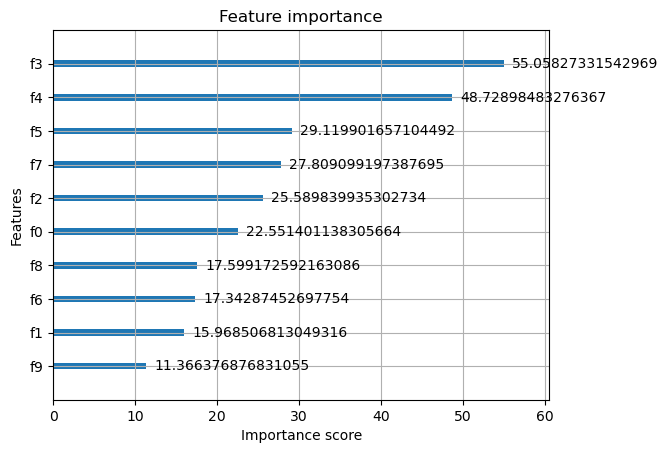

In [38]:
from xgboost import plot_importance

plot_importance(clf, importance_type='gain')  # best metric
plt.show()

In [48]:
!pip install supertree

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'supertree' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'supertree'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for supertree: filename=supertree-0.5.5-py3-none-any.whl size=224005 sha256=93fd068d21941bcffb60c350681a9982e992a2761996e5a0218cc9ee7c1817d2
  Stored in directory: /home/idies/.cache/pip/wheels/94/d5/5f/2e4b444abd02194d56fa70a3ad54a41c856f5a680a23882100
Successfully built supertree


In [20]:
xgboost.plot_tree(clf, num_trees=0, rankdir='LR')

NameError: name 'xgboost' is not defined